กำลังดึงข้อมูลจาก database...
ข้อมูล 24559 แถว
รัน SMA50-200 Backtest...
สถิติ Backtest:
Start                                 1927-12-30 00:00:00
End                                   2025-10-08 00:00:00
Period                                24559 days 00:00:00
Start Value                                      100000.0
End Value                                 36117816.526458
Total Return [%]                             36017.816526
Benchmark Return [%]                         37962.626961
Max Gross Exposure [%]                              100.0
Total Fees Paid                             473163.785709
Max Drawdown [%]                                49.188882
Max Drawdown Duration                  2058 days 00:00:00
Total Trades                                           51
Total Closed Trades                                    50
Total Open Trades                                       1
Open Trade PnL                             2781441.969224
Win Rate [%]                             

/var/folders/5k/4_qkk15n2fx39fmtxg63lb700000gn/T/ipykernel_65504/1804768466.py:79: UserWarning:

This axis already has a converter set and is updating to a potentially incompatible converter



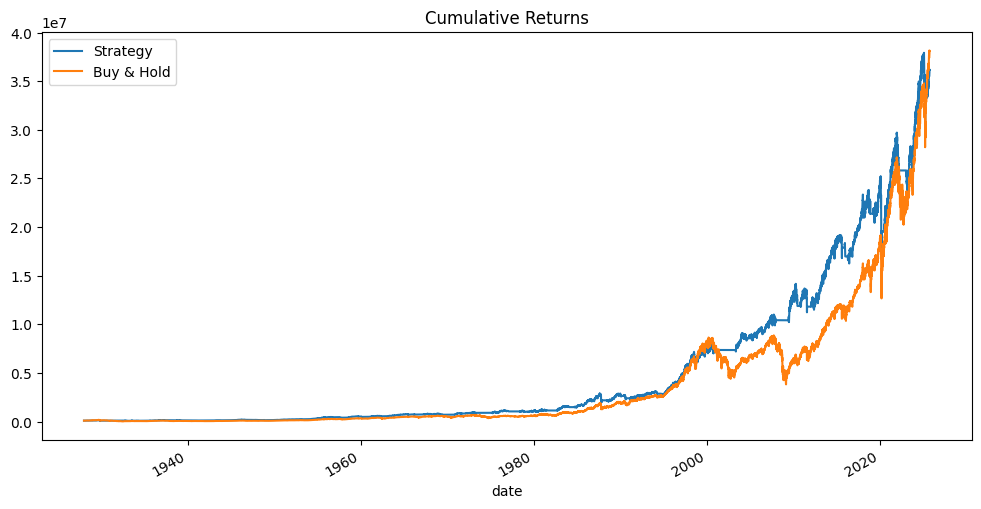

In [5]:
import os
from dotenv import load_dotenv
import pandas as pd
from sqlalchemy import create_engine
import vectorbt as vbt
import matplotlib.pyplot as plt

# ---------------------------
# ตั้งค่า environment
# ---------------------------
load_dotenv()  # โหลด .env

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")
TABLE_NAME = "sp500_prices"

if not all([DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME]):
    raise RuntimeError("กรุณาตั้งค่า environment variables (DB_USER, DB_PASSWORD, DB_HOST, DB_PORT, DB_NAME)")

DB_URI = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DB_URI)

# ---------------------------
# ดึงข้อมูล Close จาก DB
# ---------------------------
def get_close_data():
    query = f'SELECT date, "Close" FROM {TABLE_NAME} ORDER BY date'
    df = pd.read_sql(query, con=engine)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)
    df.set_index('date', inplace=True)
    return df['Close']  # คืนเป็น Series เดียว

# ---------------------------
# SMA50-200 Crossover Backtest
# ---------------------------
def sma_crossover_backtest(short_window=50, long_window=200):
    close = get_close_data()

    # สร้าง Signal
    sma_short = close.rolling(window=short_window).mean()
    sma_long = close.rolling(window=long_window).mean()

    entries = sma_short > sma_long
    exits = sma_short <= sma_long

    # Portfolio
    pf = vbt.Portfolio.from_signals(
        close,
        entries,
        exits,
        init_cash=100_000,
        fees=0.001,
        freq="1D"  # ระบุความถี่
    )

    return pf, close

# ---------------------------
# Main: รัน Backtest + Plot
# ---------------------------
if __name__ == "__main__":
    print("กำลังดึงข้อมูลจาก database...")
    close = get_close_data()
    print(f"ข้อมูล {len(close)} แถว")

    print("รัน SMA50-200 Backtest...")
    pf, close = sma_crossover_backtest(short_window=50, long_window=200)

    print("สถิติ Backtest:")
    print(pf.stats())

    # Plot cumulative return
    plt.figure(figsize=(12,6))
    pf.value().plot(label='Strategy')
    plt.plot((1 + close.pct_change().fillna(0)).cumprod() * 100_000, label='Buy & Hold')
    plt.legend()
    plt.title('Cumulative Returns')
    plt.show()
